In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
from PIL import Image, ImageDraw

Dataset with variations created successfully!


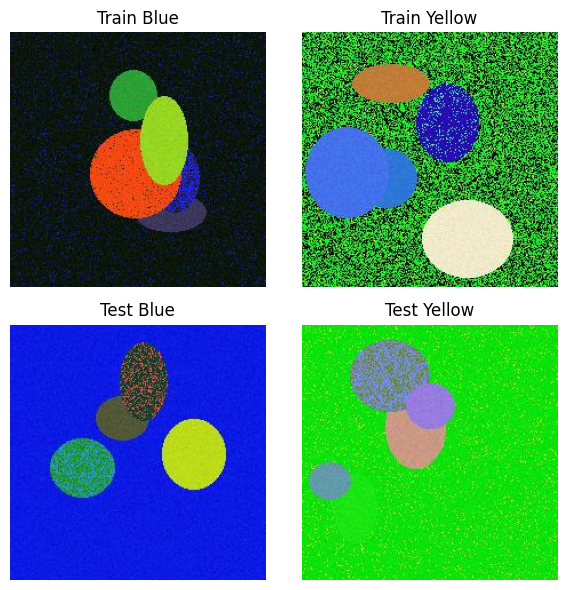

In [3]:
# Створення структури папок
folders = [
   "dataset/train/blue", "dataset/train/yellow",
   "dataset/test/blue",  "dataset/test/yellow"
]

for folder in folders:
   os.makedirs(folder, exist_ok=True)

def create_random_colored_image(base_color, path, size=(224, 224)):
   """
   base_color : tuple → (0,0,255) or (255,255,0)
   додаємо шум та випадкові форми, щоб дані не були однаковими
   """

   # створюємо фоновий колір з варіацією
   variation = np.random.randint(-40, 40, size=3)
   color = tuple(np.clip(np.array(base_color) + variation, 0, 255).astype(int))

   img = Image.new("RGB", size, tuple(color))
   draw = ImageDraw.Draw(img)

   # випадкові круги
   for _ in range(5):
      x1, y1 = np.random.randint(0, 150, size=2)
      x2, y2 = x1 + np.random.randint(30, 80), y1 + np.random.randint(30, 80)

      shape_color = tuple(np.random.randint(0, 255, size=3))
      draw.ellipse([x1, y1, x2, y2], fill=shape_color)

   # випадковий шум
   arr = np.array(img)
   noise = np.random.randint(0, 25, size=arr.shape, dtype='uint8')
   arr = np.clip(arr + noise, 0, 255)

   img = Image.fromarray(arr)
   img.save(path)

# Генеруємо тренувальні (100)
for i in range(100):
   create_random_colored_image((0,0,255), f"dataset/train/blue/blue_{i}.jpg")  # Синій
   create_random_colored_image((255,255,0), f"dataset/train/yellow/yellow_{i}.jpg") # Жовтий

# Генеруємо тестові (20)
for i in range(20):
   create_random_colored_image((0,0,255), f"dataset/test/blue/blue_{i}.jpg")    # Синій
   create_random_colored_image((255,255,0), f"dataset/test/yellow/yellow_{i}.jpg") # Жовтий

print("Dataset with variations created successfully!")

fig, axes = plt.subplots(2, 2, figsize=(6,6))

paths = [
   "dataset/train/blue/blue_0.jpg",
   "dataset/train/yellow/yellow_0.jpg",
   "dataset/test/blue/blue_0.jpg",
   "dataset/test/yellow/yellow_0.jpg",
]

titles = ["Train Blue", "Train Yellow", "Test Blue", "Test Yellow"]

for ax, path, title in zip(axes.flatten(), paths, titles):
   img = Image.open(path)
   ax.imshow(img)
   ax.set_title(title)
   ax.axis("off")

plt.tight_layout()
plt.show()

In [4]:
train_datagen = ImageDataGenerator(
   rescale=1./255,
   rotation_range=15,
   zoom_range=0.2,
   horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
   'dataset/train',
   target_size=(224, 224),
   batch_size=16,
   class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
   'dataset/test',
   target_size=(224, 224),
   batch_size=16,
   class_mode='binary'
)

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [5]:
model = models.Sequential([
   layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
   layers.MaxPooling2D(2,2),

   layers.Conv2D(64, (3,3), activation='relu'),
   layers.MaxPooling2D(2,2),

   layers.Conv2D(128, (3,3), activation='relu'),
   layers.MaxPooling2D(2,2),

   layers.Flatten(),
   layers.Dense(128, activation='relu'),
   layers.Dropout(0.5),
   layers.Dense(1, activation='sigmoid')
])

model.compile(
   optimizer='adam',
   loss='binary_crossentropy',
   metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
   train_data,
   validation_data=test_data,
   epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6651 - loss: 0.6460 - val_accuracy: 0.9500 - val_loss: 0.1228
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9618 - loss: 0.1411 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9882 - loss: 0.0213 - val_accuracy: 0.9000 - val_loss: 0.3644
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9500 - val_loss: 0.1725
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9993 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 2.0427e-06
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9698 - loss: 0.0697 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9283 - loss: 0.3849 - val_accuracy: 0.9500 - val_loss: 0.0604
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9793 - loss: 0.0430 - val_accuracy: 0.9750 - val_l

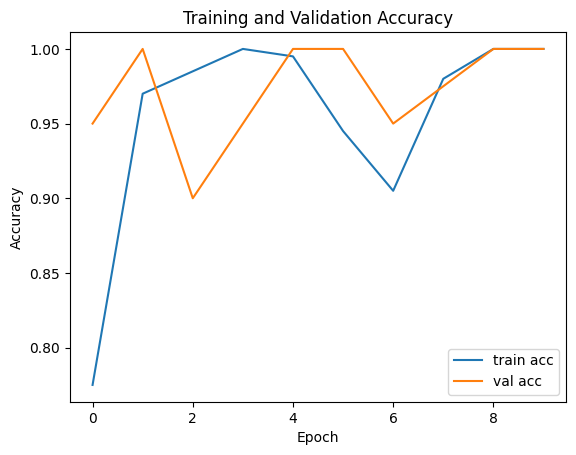

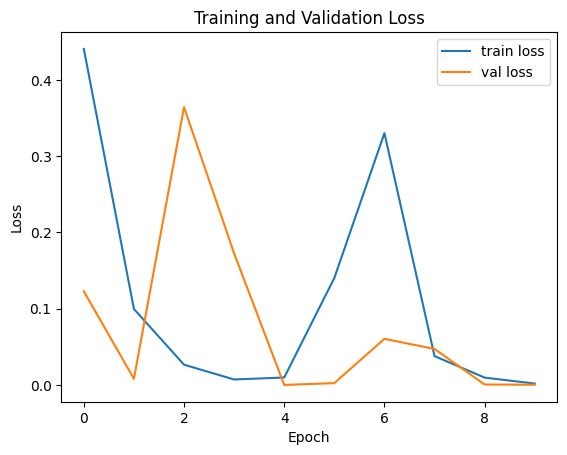

In [7]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Отримуємо передбачення
preds = model.predict(test_data)
preds = (preds > 0.5).astype(int)

# Реальні значення
true = test_data.classes

# 'blue' (class 0) та 'yellow' (class 1)
print(classification_report(true, preds, target_names=['blue', 'yellow']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 967ms/step
              precision    recall  f1-score   support

        blue       0.50      0.50      0.50        20
      yellow       0.50      0.50      0.50        20

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.50        40
weighted avg       0.50      0.50      0.50        40

